The following example consists of a simple mechanics problem.

In [1]:
import os
from pathlib import Path

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [2]:
import ogstools as ot

prj_name = "SimpleMechanics"
model = ot.Project(output_file=(out_dir / f"{prj_name}.prj"))
model.geometry.add_geometry(filename="./square_1x1.gml")
model.mesh.add_mesh(filename="./square_1x1_quad_1e2.vtu")
model.processes.set_process(
    name="SD",
    type="SMALL_DEFORMATION",
    integration_order="2",
    specific_body_force="0 0",
)
model.processes.set_constitutive_relation(
    type="LinearElasticIsotropic", youngs_modulus="E", poissons_ratio="nu"
)
model.processes.add_process_variable(
    process_variable="process_variable", process_variable_name="displacement"
)
model.processes.add_secondary_variable(internal_name="sigma", output_name="sigma")
model.time_loop.add_process(
    process="SD",
    nonlinear_solver_name="basic_newton",
    convergence_type="DeltaX",
    norm_type="NORM2",
    abstol="1e-15",
    time_discretization="BackwardEuler",
)
model.time_loop.set_stepping(
    process="SD",
    type="FixedTimeStepping",
    t_initial="0",
    t_end="1",
    repeat="4",
    delta_t="0.25",
)
model.time_loop.add_output(
    type="VTK",
    prefix=prj_name,
    repeat="1",
    each_steps="4",
    variables=["displacement", "sigma"],
)
model.media.add_property(
    medium_id="0", phase_type="Solid", name="density", type="Constant", value="1"
)
model.parameters.add_parameter(name="E", type="Constant", value="1")
model.parameters.add_parameter(name="nu", type="Constant", value="0.3")
model.parameters.add_parameter(name="displacement0", type="Constant", values="0 0")
model.parameters.add_parameter(name="dirichlet0", type="Constant", value="0")
model.parameters.add_parameter(name="dirichlet1", type="Constant", value="0.05")
model.process_variables.set_ic(
    process_variable_name="displacement",
    components="2",
    order="1",
    initial_condition="displacement0",
)
model.process_variables.add_bc(
    process_variable_name="displacement",
    geometrical_set="square_1x1_geometry",
    geometry="left",
    type="Dirichlet",
    component="0",
    parameter="dirichlet0",
)
model.process_variables.add_bc(
    process_variable_name="displacement",
    geometrical_set="square_1x1_geometry",
    geometry="bottom",
    type="Dirichlet",
    component="1",
    parameter="dirichlet0",
)
model.process_variables.add_bc(
    process_variable_name="displacement",
    geometrical_set="square_1x1_geometry",
    geometry="top",
    type="Dirichlet",
    component="1",
    parameter="dirichlet1",
)
model.nonlinear_solvers.add_non_lin_solver(
    name="basic_newton",
    type="Newton",
    max_iter="4",
    linear_solver="general_linear_solver",
)
model.linear_solvers.add_lin_solver(
    name="general_linear_solver",
    kind="lis",
    solver_type="cg",
    precon_type="jacobi",
    max_iteration_step="10000",
    error_tolerance="1e-16",
)
model.linear_solvers.add_lin_solver(
    name="general_linear_solver",
    kind="eigen",
    solver_type="CG",
    precon_type="DIAGONAL",
    max_iteration_step="10000",
    error_tolerance="1e-16",
)
model.linear_solvers.add_lin_solver(
    name="general_linear_solver",
    kind="petsc",
    prefix="sd",
    solver_type="cg",
    precon_type="bjacobi",
    max_iteration_step="10000",
    error_tolerance="1e-16",
)
try:
    model.write_input()
    model.run_model(
        logfile=(out_dir / f"{prj_name}-out.txt"), args=f"-o {out_dir} -m ."
    )
except Exception as inst:
    print(f"{type(inst)}: {inst.args[0]}")

from datetime import datetime

print(datetime.now())

OGS finished with project file _out/SimpleMechanics.prj.
Execution took 0.07593870162963867 s
Project file written to output.
2024-07-18 09:49:58.202452


Text(0, 0.5, 'u')

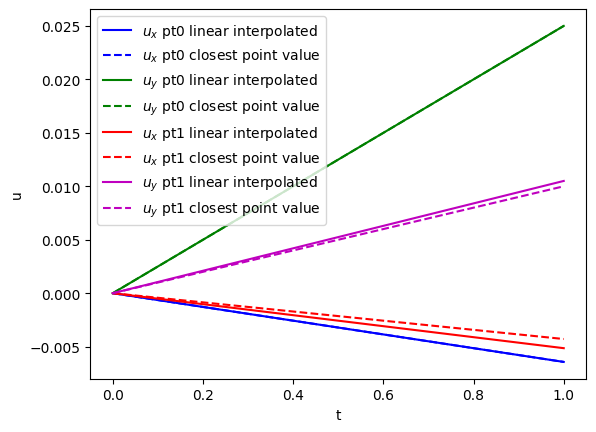

In [3]:
import vtuIO

pvdfile = vtuIO.PVDIO(f"{out_dir}/{prj_name}.pvd", interpolation_backend="scipy", dim=2)
time = pvdfile.timesteps
points = {"pt0": (0.3, 0.5, 0.0), "pt1": (0.24, 0.21, 0.0)}
displacement_linear = pvdfile.read_time_series(
    "displacement", points, interpolation_method="linear"
)
displacement_nearest = pvdfile.read_time_series(
    "displacement", points, interpolation_method="nearest"
)

import matplotlib.pyplot as plt

plt.plot(
    time, displacement_linear["pt0"][:, 0], "b-", label="$u_x$ pt0 linear interpolated"
)
plt.plot(
    time,
    displacement_nearest["pt0"][:, 0],
    "b--",
    label="$u_x$ pt0 closest point value",
)
plt.plot(
    time, displacement_linear["pt0"][:, 1], "g-", label="$u_y$ pt0 linear interpolated"
)
plt.plot(
    time,
    displacement_nearest["pt0"][:, 1],
    "g--",
    label="$u_y$ pt0 closest point value",
)
plt.plot(
    time, displacement_linear["pt1"][:, 0], "r-", label="$u_x$ pt1 linear interpolated"
)
plt.plot(
    time,
    displacement_nearest["pt1"][:, 0],
    "r--",
    label="$u_x$ pt1 closest point value",
)
plt.plot(
    time, displacement_linear["pt1"][:, 1], "m-", label="$u_y$ pt1 linear interpolated"
)
plt.plot(
    time,
    displacement_nearest["pt1"][:, 1],
    "m--",
    label="$u_y$ pt1 closest point value",
)
plt.legend()
plt.xlabel("t")
plt.ylabel("u")

In [25]:
import matplotlib.pyplot as plt
import numpy as np

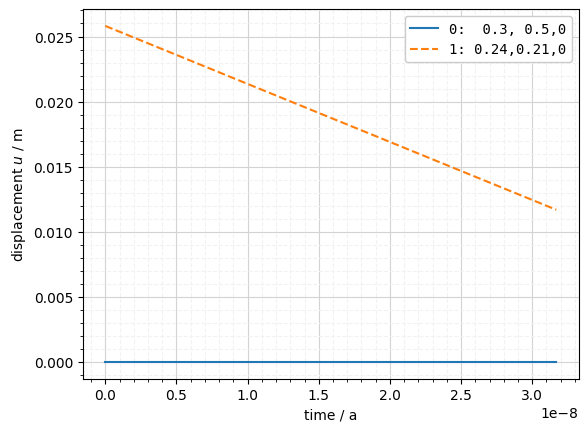

In [26]:
mesh_series = ot.MeshSeries(f"{out_dir}/{prj_name}.pvd")
points = np.asarray([[0.3, 0.5, 0.0], [0.24, 0.21, 0.0]])
disp = ot.variables.displacement
labels = [
    f"{i}: {label}" for i, label in enumerate(ot.plot.utils.justified_labels(points))
]
fig = mesh_series.plot_probe(
    points=points, variable=disp, time_unit="a", labels=labels
)